# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle



# Importing Libraries

In [1]:
%matplotlib inline

import os
import torch
import random
import torchvision
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0+cu101


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Creating Custom Dataset

In [7]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name])[:300] if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        all_images = self.images[self.class_names[0]] \
          + self.images[self.class_names[1]] \
          + self.images[self.class_names[2]]
        all_class_names = [self.class_names[0]]*len(self.images[self.class_names[0]]) \
          + [self.class_names[1]]*len(self.images[self.class_names[1]]) \
          + [self.class_names[2]]*len(self.images[self.class_names[2]])
        image_name = all_images[index]
        class_name = all_class_names[index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [9]:
train_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, transform)

Found 300 normal examples
Found 300 viral examples
Found 159 covid examples


In [10]:
dev_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/dev/covid'
}

dev_dataset = ChestXRayDataset(dev_dirs, transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [11]:
test_dirs = {
    'normal': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/normal',
    'viral': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/viral',
    'covid': 'drive/My Drive/dataset/COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [12]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_dev = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of dev batches', len(dl_dev))
print('Number of test batches', len(dl_test))


Number of training batches 127
Number of dev batches 15
Number of test batches 15


# Data Visualization

In [ ]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

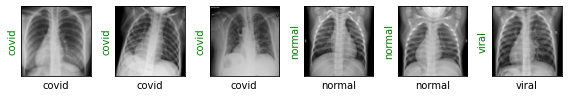

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

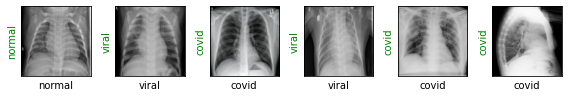

In [ ]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [ ]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_dev))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

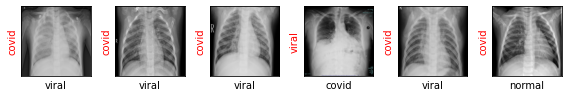

In [ ]:
show_preds()

# Training the Model

In [ ]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(f'Train Loss: {train_loss:.4f}')
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_dev):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Dev Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train() # set model to training phase

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/1
Train Loss: 1.4663
Evaluating at step 0
Dev Loss: 1.1919, Accuracy: 0.2889


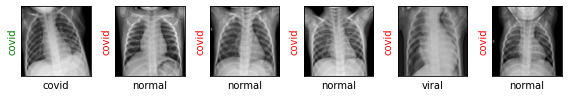

Train Loss: 2.9313
Train Loss: 3.8931
Train Loss: 4.7737
Train Loss: 5.5988
Train Loss: 6.4627
Train Loss: 7.5959
Train Loss: 8.3868
Train Loss: 9.3754
Train Loss: 10.1749
Train Loss: 10.7784
Train Loss: 11.9324
Train Loss: 12.6732
Train Loss: 13.4137
Train Loss: 14.0265
Train Loss: 14.8530
Train Loss: 15.8196
Train Loss: 16.2741
Train Loss: 16.7966
Train Loss: 17.5265
Train Loss: 18.0179
Evaluating at step 20
Dev Loss: 0.7827, Accuracy: 0.7222


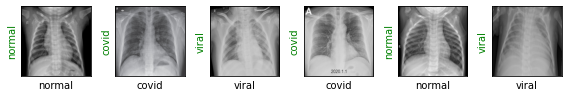

Train Loss: 18.7273
Train Loss: 19.3269
Train Loss: 19.7036
Train Loss: 20.0499
Train Loss: 20.4217
Train Loss: 20.8015
Train Loss: 21.0484
Train Loss: 21.5170
Train Loss: 21.7083
Train Loss: 21.9428
Train Loss: 22.1949
Train Loss: 22.6323
Train Loss: 23.7795
Train Loss: 24.4052
Train Loss: 24.6454
Train Loss: 25.2741
Train Loss: 25.8481
Train Loss: 26.4510
Train Loss: 26.7894
Train Loss: 27.0531
Evaluating at step 40
Dev Loss: 0.3421, Accuracy: 0.8778


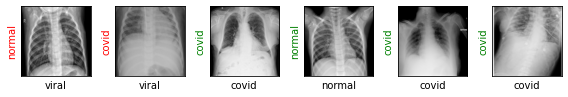

Train Loss: 27.2776
Train Loss: 27.6618
Train Loss: 28.1014
Train Loss: 28.2912
Train Loss: 28.5832
Train Loss: 28.7340
Train Loss: 29.1548
Train Loss: 29.4055
Train Loss: 29.5440
Train Loss: 29.6994
Train Loss: 29.8123
Train Loss: 29.9178
Train Loss: 30.3169
Train Loss: 31.0262
Train Loss: 31.7125
Train Loss: 32.5617
Train Loss: 33.4832
Train Loss: 34.2260
Train Loss: 34.2735
Train Loss: 34.3984
Evaluating at step 60
Dev Loss: 0.2321, Accuracy: 0.9333


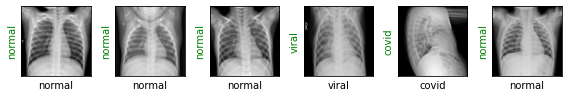

Train Loss: 34.5229
Train Loss: 34.7944
Train Loss: 34.8586
Train Loss: 35.0821
Train Loss: 35.2867
Train Loss: 35.5065
Train Loss: 36.0538
Train Loss: 36.4183
Train Loss: 36.6648
Train Loss: 37.1314
Train Loss: 37.1925
Train Loss: 37.3145
Train Loss: 37.7741
Train Loss: 38.1211
Train Loss: 38.6704
Train Loss: 39.9658
Train Loss: 40.0599
Train Loss: 40.3311
Train Loss: 41.0053
Train Loss: 41.5385
Evaluating at step 80
Dev Loss: 0.2116, Accuracy: 0.9222


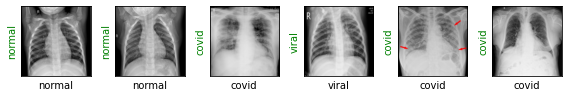

Train Loss: 41.5931
Train Loss: 41.6713
Train Loss: 41.8242
Train Loss: 42.0122
Train Loss: 42.0711
Train Loss: 42.7138
Train Loss: 42.7984
Train Loss: 42.9903
Train Loss: 43.6867
Train Loss: 44.9244
Train Loss: 44.9842
Train Loss: 45.8755
Train Loss: 46.2525
Train Loss: 46.4227
Train Loss: 46.5359
Train Loss: 46.6758
Train Loss: 46.7803
Train Loss: 47.4088
Train Loss: 47.9247
Train Loss: 47.9824
Evaluating at step 100
Dev Loss: 0.2873, Accuracy: 0.8778


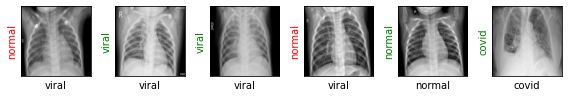

Train Loss: 48.0444
Train Loss: 48.4303
Train Loss: 48.5079
Train Loss: 48.8438
Train Loss: 48.9747
Train Loss: 49.4601
Train Loss: 50.1335
Train Loss: 50.2038
Train Loss: 50.3184
Train Loss: 50.4911
Train Loss: 50.6184
Train Loss: 50.8485
Train Loss: 51.4252
Train Loss: 51.5827
Train Loss: 51.7123
Train Loss: 51.7780
Train Loss: 52.1425
Train Loss: 52.3759
Train Loss: 52.5267
Train Loss: 52.5985
Evaluating at step 120
Dev Loss: 0.2026, Accuracy: 0.9333


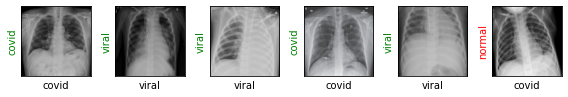

Train Loss: 52.6341
Train Loss: 52.7205
Train Loss: 53.5836
Train Loss: 53.6734
Train Loss: 53.7469
Train Loss: 53.9138
Train Loss: 54.0826
Train Loss: 54.6242
Train Loss: 54.6692
Train Loss: 54.7209
Train Loss: 54.9016
Train Loss: 55.6838
Train Loss: 55.8319
Train Loss: 56.1149
Train Loss: 56.3540
Train Loss: 56.6098
Train Loss: 56.6282
Train Loss: 56.7385
Train Loss: 56.7953
Train Loss: 56.8626
Evaluating at step 140
Dev Loss: 0.2792, Accuracy: 0.9000


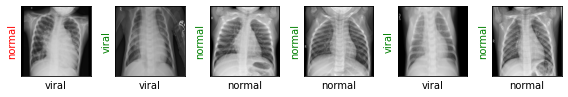

Train Loss: 57.0856
Train Loss: 57.1932
Train Loss: 57.8744
Train Loss: 58.5845
Train Loss: 58.6651
Train Loss: 58.7148
Train Loss: 58.9250
Train Loss: 59.1444
Train Loss: 59.2360
Train Loss: 59.2977
Train Loss: 59.7767
Train Loss: 59.9325
Train Loss: 60.1687
Train Loss: 60.3986
Train Loss: 60.5558
Train Loss: 60.6385
Train Loss: 61.7394
Train Loss: 61.7961
Train Loss: 61.9881
Train Loss: 62.1300
Evaluating at step 160
Dev Loss: 0.1903, Accuracy: 0.9444


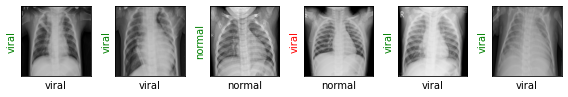

Train Loss: 62.1595
Train Loss: 62.3134
Train Loss: 62.3611
Train Loss: 62.8659
Train Loss: 63.1545
Train Loss: 63.2053
Train Loss: 63.4657
Train Loss: 63.7284
Train Loss: 63.9391
Train Loss: 64.0190
Train Loss: 64.1189
Train Loss: 64.1976
Train Loss: 64.2800
Train Loss: 64.4364
Train Loss: 64.5542
Train Loss: 64.6037
Train Loss: 64.7969
Train Loss: 65.1321
Train Loss: 65.4509
Train Loss: 65.4815
Evaluating at step 180
Dev Loss: 0.2634, Accuracy: 0.8667


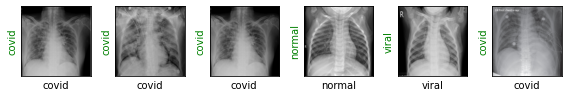

Train Loss: 65.5116
Train Loss: 65.7354
Train Loss: 66.0685
Train Loss: 66.3632
Train Loss: 66.6823
Train Loss: 66.7020
Train Loss: 67.0217
Train Loss: 67.4973
Train Loss: 68.1216
Train Loss: 68.2561
Train Loss: 68.4494
Train Loss: 68.4807
Train Loss: 68.6657
Train Loss: 68.7416
Train Loss: 68.8962
Train Loss: 69.1419
Train Loss: 69.3075
Train Loss: 69.4634
Train Loss: 70.0421
Train Loss: 70.0641
Evaluating at step 200
Dev Loss: 0.1749, Accuracy: 0.9222


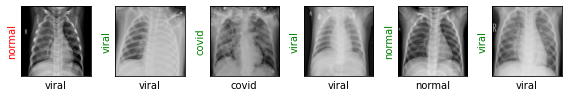

Train Loss: 70.1175
Train Loss: 70.2092
Train Loss: 70.2689
Train Loss: 70.2818
Train Loss: 71.3332
Train Loss: 71.5006
Train Loss: 71.7552
Train Loss: 71.7769
Train Loss: 71.9641
Train Loss: 72.0765
Train Loss: 72.2426
Train Loss: 72.2877
Train Loss: 72.6928
Train Loss: 72.9425
Train Loss: 72.9548
Train Loss: 73.0669
Train Loss: 73.6792
Train Loss: 73.7302
Train Loss: 73.8149
Train Loss: 73.8785
Evaluating at step 220
Dev Loss: 0.2727, Accuracy: 0.8778


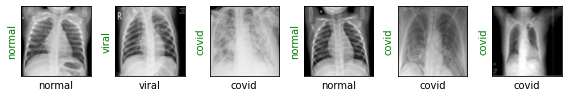

Train Loss: 73.8899
Train Loss: 74.4963
Train Loss: 74.7068
Train Loss: 75.2845
Train Loss: 75.5609
Train Loss: 75.6565
Train Loss: 75.6797
Train Loss: 75.9708
Train Loss: 76.0619
Train Loss: 76.4005
Train Loss: 76.4684
Train Loss: 76.5271


KeyboardInterrupt: ignored

In [ ]:
%%time

train(epochs=1)

# Final Results

Mismatched examples analysis

In [ ]:
resnet18.eval()
labels_all = []
preds_all = []
for i, (images, labels) in enumerate(dl_test):
    output = resnet18(images)
    _, preds = torch.max(output, 1)
    labels_all += labels
    preds_all += preds

tensor([1, 0, 0, 2, 2, 2]) tensor([1, 0, 0, 2, 2, 2])
tensor([0, 0, 2, 1, 2, 0]) tensor([0, 0, 2, 1, 2, 0])
tensor([1, 1, 2, 0, 1, 2]) tensor([1, 1, 2, 0, 1, 2])
tensor([2, 1, 0, 2, 1, 2]) tensor([2, 1, 0, 2, 1, 2])
tensor([2, 2, 0, 1, 2, 1]) tensor([2, 2, 0, 1, 2, 1])
tensor([2, 2, 1, 1, 2, 1]) tensor([2, 2, 1, 1, 2, 1])
tensor([0, 0, 1, 2, 0, 0]) tensor([0, 0, 1, 2, 0, 0])
tensor([1, 2, 0, 0, 1, 2]) tensor([1, 2, 0, 0, 1, 2])
tensor([2, 1, 2, 2, 0, 1]) tensor([2, 1, 2, 2, 0, 1])
tensor([0, 0, 1, 0, 2, 1]) tensor([0, 0, 1, 0, 2, 1])
tensor([1, 1, 1, 2, 0, 1]) tensor([1, 0, 1, 2, 0, 1])
tensor([2, 0, 1, 0, 0, 1]) tensor([2, 0, 1, 0, 0, 1])
tensor([0, 1, 0, 1, 1, 1]) tensor([2, 1, 0, 1, 1, 1])
tensor([2, 0, 2, 0, 2, 0]) tensor([2, 0, 2, 0, 2, 0])
tensor([0, 0, 0, 2, 1, 2]) tensor([0, 0, 0, 2, 1, 2])


In [ ]:
comparison_df = pd.DataFrame(labels_all).rename(columns={0: 'labels'})
comparison_df['preds'] = [int(preds_all_el) for preds_all_el in preds_all]
comparison_df['misclassified'] = comparison_df.apply(lambda col: col['labels'] != col['preds'], axis=1)
comparison_df.head()

,labels,preds,misclassified
0,1,1,True
1,0,0,True
2,0,0,True
3,2,2,True
4,2,2,True


In [ ]:
comparison_df[comparison_df['misclassified'] == True]

,labels,preds,misclassified
61,1,0,False
72,0,2,False


# Confusion Matrix

In [ ]:
resnet18.eval() # set model to eval phase

nb_classes = 3

with torch.no_grad():
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    for i, (images, labels) in enumerate(dl_test):
        outputs = resnet18(images)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), preds.view(-1)):
          confusion_matrix[t.long(), p.long()] += 1

    print(class_names)
    print(confusion_matrix)

['normal', 'viral', 'covid']
tensor([[29.,  0.,  1.],
        [ 1., 29.,  0.],
        [ 0.,  0., 30.]])


# Show the training/dev curve